Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "slava-qw"

---

In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag

Рассмотрим систему линейных уравнений, матрица правой части которой является "ленточной" и имеет следующую структуру: ненулевые элементы расположены на трех центральных диагонялях и на двух "крыльях". Матрицы такой структуры возникают, например, при решении задачи на нахождение электростатического потенциала $\phi(x, y)$, cоздаваемого двумерным распределением заряда $\rho(x, y)$ при дискретизации на сетке уравнения Пуассона

$$
\Delta \phi = -4\pi \rho\;.
$$
Мы будем решать эту задачу для простоты на квадрате с нулевым потенциалом на границе.
Простейшая сеточная аппроксимация - $\phi(x_i,y_j) = \phi_{ij}$ "схема крест"
$$
\frac{u_{i-1,j} - 2 u_{ij}+u_{i+1,j}}{h^2} + \frac{u_{i,j-1} - 2 u_{ij}+u_{i,j+1}}{h^2} = \rho_{ij}.
$$
(детали см. напр. А.А. Самарский, А.В. Гулин, Численные методы, ч. 3 гл. 1, параграф 1).

Заметим, что эти уравнения верны для внутренних узлов сетки, а поскольку внешние узлы сетки равны нулю, они войдут с нулевыми коэффициентами в уравнения на внутрении и можно о внешних узлах просто забыть.

Представим вектор решение в виде одномерного вектора по правилу $\phi_{i,j} = y_{j\cdot n+i}$, где $n$ - число внутренних узлов на строне квадрата.

Тогда всю систему уравнений можно представить в виде:
$$
\hat{m} \mathbf{y} = \mathbf{\tilde{f}}, 
$$
где матрица $m$ имеет блочную структуру, отвечающую вычислениям производных по оси x (при неизменном j) и два крыла, отвечающие соседним по $y$ клеткам, то есть их индекс сдвинут ровно на $n$. 


Размер матрицы растет с уменьшением шага сетки $h$ как $O(1/h^2)$. Таким образом, приходится иметь дело с разреженными матрицами огромного размера.

Матрицу `m` создадим следующим образом:

In [3]:
def lhs_matrix(n:int):
    # Диагональный блок
    a = np.zeros((n, n))

    idx = np.arange(n)

    a[idx, idx] = -4 # u_{ij}
    a[idx[:-1], idx[:-1] + 1] = 1 # соседи по x
    a[idx[1:], idx[1:] - 1] = 1

    # собираем блочно-диагональную матрицу `m`
    m = block_diag(*(a,)*n)

    # заполняем "крылья" - соседи по y
    idx = np.arange(m.shape[0])

    m[idx[:-n], idx[:-n] + n] = 1
    m[idx[n:], idx[n:] - n] = 1
    return m

In [4]:
m = lhs_matrix(3)

with np.printoptions(linewidth=99):
    print(m)

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


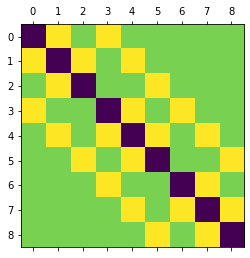

In [5]:
import matplotlib.pyplot as plt
plt.matshow(m)

Зададим вектор правой части системы $b$, символизирующий точечный заряд в центре: (для нечетного n)

In [6]:
b = np.zeros(m.shape[0])
b[m.shape[0] // 2] = -1

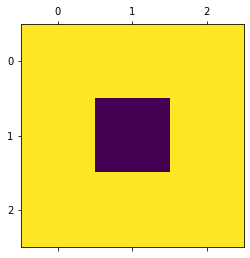

In [7]:
plt.matshow(b.reshape(3, 3))

Составьте функцию, вычисляющую решение системы уравнений $m x = b$ **методом Зейделя** с заданной точностью $\epsilon$.

Не пользуйтесь функциями `np.linalg.solve`, `np.linalg.inv` и т.п. Обратите внимание на функции `np.triu` и `scipy.linalg.solve_triangular`.

In [8]:
from scipy.linalg import solve_triangular
# see also: https://en.wikipedia.org/wiki/Gauss–Seidel_method
# and https://ru.wikipedia.org/wiki/Метод_Гаусса_—_Зейделя_решения_системы_линейных_уравнений
def seidel_solve(m, b, x0, eps=1e-5, maxiter=500):
    """ Solve `m @ x = b` with Seidel iteration.
    
    Parameters
    ----------
    m : ndarray, shape (n, n)
       Input matrix
    b : ndarray, shape (n,)
       Right-hand side
    x0 : ndarray, shape (n, )
       Initial point for the iteration
    eps : float, optional
       Target accuracy.
       Stop iterations when the 2-norm of 
       `|x_k - x_{k-1}| < eps`
    maxiter : int
       Maximum allowed number of iterations.
       
    Returns
    -------
    x : ndarray, shape (n,)
       The approximation to the solution of `m @ x = b`
    nit : the number of iterations performed.
    """
    x = x0
    converge = False
    nit = 1

    while not converge or nit >= maxiter:
        x_kp1 = np.copy(x)
        L_star = np.triu(m)
        U = np.tril(m, k=-1)
        
        x_kp1 = solve_triangular(L_star, b - U @ x)

        converge = np.linalg.norm(x_kp1 - x) <= eps
        x = x_kp1
        nit +=1

    return x, nit 


In [9]:
m = lhs_matrix(n=6)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0)

from numpy.testing import assert_allclose
assert_allclose(x,
                np.linalg.solve(m, b), atol=2e-5)


Прокомментируйте зависимость числа итераций, требуемых для достижения заданной точности, от $\epsilon$, построив соовествующие график для какого-нибудь примера.

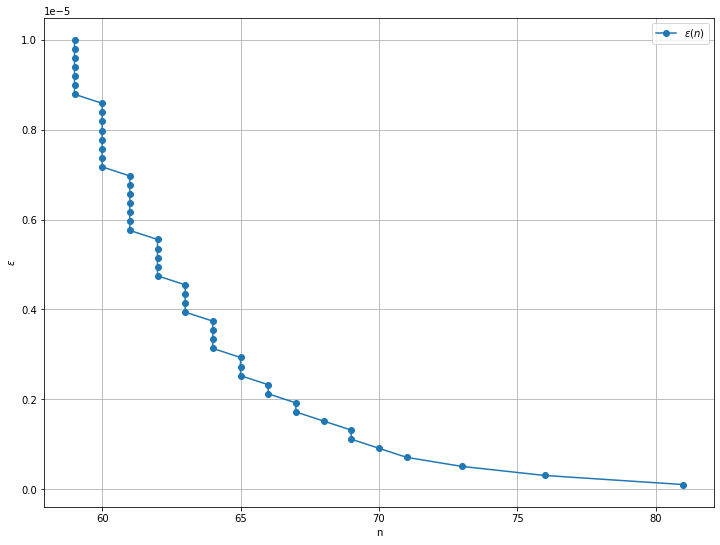

In [10]:
eps_list = np.linspace(1e-7, 1e-5)
x0 = np.ones(m.shape[0])
m = lhs_matrix(n=6)
b = np.zeros(m.shape[0])
b[b.size // 2] = 1

epsilist = []
nitalist = []

plt.figure(figsize=(12, 9))
for eps in eps_list:
    _, nit = seidel_solve(m, b, x0, eps)

    nitalist.append(nit)
    epsilist.append(eps)
    
plt.plot(nitalist, epsilist, 'o-', label=r'$\varepsilon(n)$')
plt.xlabel('n')
plt.ylabel(r'$\varepsilon$')
# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Видно, что число итераций растет с увеличением точности решения,
# причем если построить зависисимость логарифма погрешности, то мы увидим линейный спад,
# то есть погрешность "спадает" по экспоненте от числа итераций


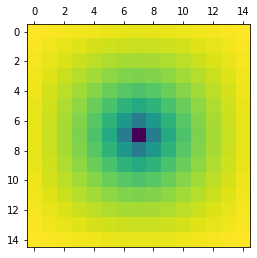

In [11]:
# Построим решение
m = lhs_matrix(n=15)
b = np.zeros(m.shape[0])
b[b.size//2] = 1


x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0, eps=1e-6, maxiter=1000)
x_res=x.reshape(15,15)
plt.matshow(x_res)

## если вы всё сделали правильно, ничего удивительного мы тут не увидим

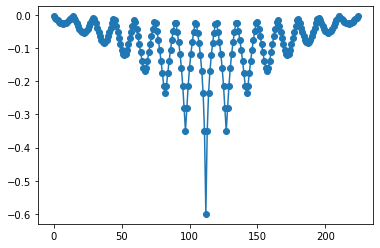

In [12]:
# Однако в нашем одномерном представлении зависимость менее тривиальна:
plt.plot(x, 'o-')
# Прокомментируйте характер зависимости значения от номера компоненты в ячейке ниже


В 'центре', как и было задано по условию, будет всплеск значения, а так как мы изменили форму решения на одномерное, то 'по краям' будут колебания, что видно, если посмотреть на рисунок из предыдущей ячейки для двумерного представления решения и все строки записать в одну строкчку.